## **Twitter Emotion Recognition using RNN**

---

[Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## 1. Installing Hugging Face's nlp package

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7MB 12.4MB/s 
     |████████████████████████████████| 245kB 50.8MB/s 


## 2. Importing the libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 3. Importing the Dataset

In [4]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

In [9]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

## 4. Tokenizing the Tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


## 5. Padding and Truncating Sequences

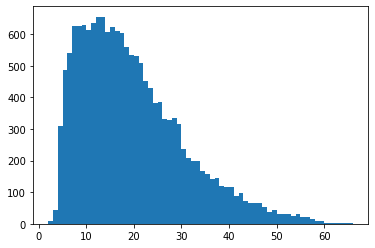

In [12]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [15]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [16]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## 6. Preparing the Labels

In [17]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'love', 'anger', 'fear', 'sadness'}


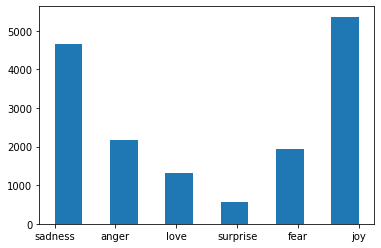

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [19]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [20]:
classes_to_index

{'anger': 3, 'fear': 4, 'joy': 1, 'love': 2, 'sadness': 5, 'surprise': 0}

In [21]:
index_to_classes

{0: 'surprise', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'sadness'}

In [22]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [23]:
train_labels = names_to_ids(labels)
print(train_labels[10])

5


## 7. Creating the Model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8. Training the Model

In [25]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [26]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', 4)

In [27]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 43s 16ms/step - loss: 1.5259 - accuracy: 0.3709 - val_loss: 0.9029 - val_accuracy: 0.6750
Epoch 2/15
500/500 [==============================] - 7s 14ms/step - loss: 0.6728 - accuracy: 0.7521 - val_loss: 0.5371 - val_accuracy: 0.8195
Epoch 3/15
500/500 [==============================] - 7s 13ms/step - loss: 0.3325 - accuracy: 0.8875 - val_loss: 0.5089 - val_accuracy: 0.8340
Epoch 4/15
500/500 [==============================] - 7s 14ms/step - loss: 0.2216 - accuracy: 0.9301 - val_loss: 0.4228 - val_accuracy: 0.8725
Epoch 5/15
500/500 [==============================] - 7s 14ms/step - loss: 0.1579 - accuracy: 0.9494 - val_loss: 0.4390 - val_accuracy: 0.8740
Epoch 6/15
500/500 [==============================] - 7s 14ms/step - loss: 0.1180 - accuracy: 0.9630 - val_loss: 0.4339 - val_accuracy: 0.8820
Epoch 7/15
500/500 [==============================] - 7s 14ms/step - loss: 0.0989 - accuracy: 0.9676 - val_loss: 0.3980 - val_accuracy: 0.882

## 9. Evaluating the Model

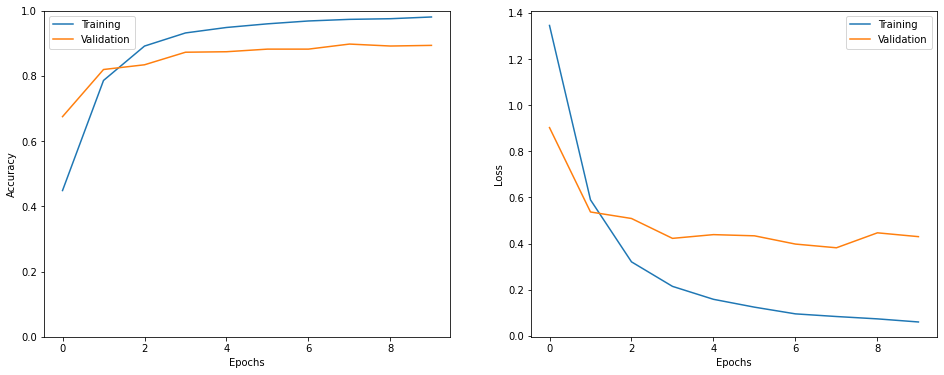

In [28]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [29]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [30]:
eval = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4190 - accuracy: 0.8880


In [31]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

  print('Predicted Emotion:', index_to_classes.get(p), '\n')

Tweet: i woke up and felt sad all over again but that was quickly replaced with a feeling that reassured me things will work themselves out on their own time
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i feel really irritated when i talk about my problems and people start talking about theirs
Actual Emotion: anger
Predicted Emotion: anger 

Tweet: i feel crappy i eat crappy
Actual Emotion: sadness
Predicted Emotion: sadness 

Tweet: i am feeling overwhelmed by trying to do it all that i think on the women before me
Actual Emotion: surprise
Predicted Emotion: fear 

Tweet: i finally arrived home a couple of hours later feeling somewhat exhausted dehydrated and even sun burnt
Actual Emotion: sadness
Predicted Emotion: sadness 



In [32]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

((2000,), (2000,))

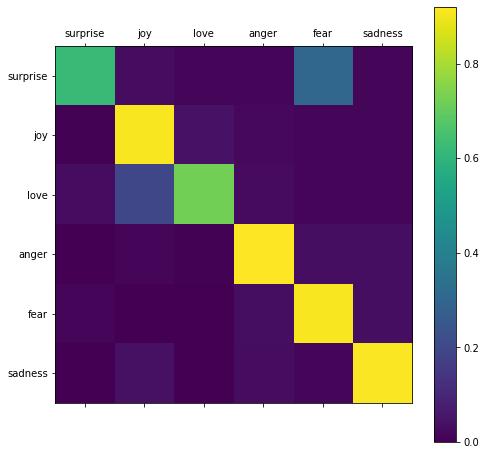

In [33]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(test_labels, preds, list(classes))